In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sortedcollections import SortedDict # Вам нужно будет установить эту библиотеку
from cg import Point # см. cg_common
from hidden import *       # Функции, реалзация которых не особо интересна в свете этой темы
from answers import *      # Ответы
from visual_utils import * # Функции визуализации

# Триангуляция многоугольника заметающей прямой

На плоскости задан произвольный многоугольник. Стороны многоугольника не пересекаются. Требуется найти его триангуляцию.

> **Простым** многоугольником называется фигура, ограниченная одной замкнутой ломаной, стороны которой не пересекаются. Т.е. это многоугольник без "дырок".

### Теорема 1 (о существовании триангуляции многоугольника)

>У любого простого многоугольника существует триангуляция, и любая триангуляция простого многоугольника с `N` вершинами содержит ровно `N-2` треугольника.

$\triangleright$
<div class="naked-img">
    <img src="illust/theorem1.svg" width=300 height=600 style="float: right;" />
</div>
<div style="padding-left:40px">
В доказательстве будем использовать индукцию по $n$ - количеству вершин многоугольника.
База индукции: $n = 3$ - многоугольник является треугольником, теорема, очевидно, верна.

Пусть $n > 3$ и для всех $m < n$ теорема верна. Рассмотрим многоугольник $P$ с $n$ вершинами и докажем, что в нём есть диагональ. Возьмём $v$ - самую левую по оси $x$ вершину $P$ (и самую нижнюю по $y$, если таких несколько). Пусть $u$ и $w$ - соседи $v$. Если отрезок $uw$ лежит внутри $P$ - мы нашли диагональ (см. рис. 1а). Иначе (рис. 1б), в треугольнике $\Delta vuw$ или на отрезке $uw$ лежит одна или несколько вершин $P$. Пусть $v'$ - самая дальняя от $uw$ из них. Отрезок $vv'$ не может пересекать ребро $P$, поскольку в противном случае одна из вершин этого ребра будет располагаться дальше от $uw$, чем $v'$, чего не может быть, исходя из определения $v'$. Значит, $vv'$ - диагональ.

Любая диагональ $P$ делит его на $P_1$ и на $P_2$. Пусть $m_1$ - количество вершин в $P_1$ и $m_2$ - в $P_2$. Заметим, что $m_1 < n$ и $m_2 < n$, поэтому по предположению индукции, триангуляции для $P_1$ и $P_2$ существуют, а значит, и существует триангуляция для $P$.

Осталось доказать, что любая триангуляция $P$ состоит из $n-2$ треугольников. Рассмотрим произвольную диагональ $d$ в какой-нибудь триангуляции $T_P$. $d$ делит $P$ на $P_1$ с $m_1$ вершин и $P_2$ с $m_2$ вершин. При этом, каждая вершина $P$ встречается в обоих частях только по одному разу, за исключением концов $d$. Отсюда, $m_1 + m_2 = n + 2$. По предположению индукции, любая триангуляция $P_i$ содержит $m_i - 2$ треугольников, поэтому $T_P$ содержит $(m_1 - 2) + (m_2 - 2) = n - 2$ треугольников, что и требовалось доказать.
</div>

$\triangleleft$

### Монотонные прямоугольники

> Простой многоугольник $P$ называется **монотонным относительно прямой $l$**, если для любой $l'\perp l$ пересечение $P$ с $l'$ связно - т.е. является пустым, точкой или отрезком.
Многоугольник, монотонный относительно оси $y$ называется *$y$-монотонным*.

<img src="illust/monotone.svg" />

*Далее в этом конспекте, если многоугольник называется монотонным без уточнения относительно какой прямой, подразумевается $y$-монотонность.*

Идея данного метода заключается в том, чтобы разбить произвольный многоугольник на $y$-монотонные куски, а затем триангулировать их.

## Разбиение многоугольника на монотонные части

Заметим, что если мы будем идти в $y$-монотонном прямоугольнике от самой верхней к самой нижней вершине по левой или правой границе, мы всегда будем опускаться (или двигаться горизонтально), но не подниматься. 

Рассмотрим произвольный многоугольник. Представим, что мы спускаемся от его верхней вершины к нижней по левой или правой границе. Те вершины, в которых мы меняем направление движения (шли вниз, теперь идём вверх, и наоборот), назовём *поворотными*. Чтобы разбить многоугольник на $y$-монотонные куски, мы должны избавиться от таких вершин. Будем проводить из них диагонали.

Для начала чётко зададим порядок на точках:

* Будем говорить, что точка $p$ *выше (меньше)* точки $q$, если $p_y > q_y$ или $p_y = q_y$ и $p_x < q_x$. Т.е. мы обрабатываем точки сверху вниз, слева направо.

* Будем говорить, что вершина многоугольника $v_j$ *выпуклая*, если тройка точек $v_{j-1}$, $v_j$ и $v_{j+1}$ образовывают левый поворот, и *невыпуклая*, если правый. 

Далее введём пять типов вершин, из которых четыре являются поворотными:

* `start` вершина - два её соседа лежат ниже неё и она выпуклая
* `split` вершина - два её соседа лежат ниже неё и она невыпуклая
* `end` вершина - два её соседа лежат выше неё и она выпуклая
* `merge` вершина - два её соседа лежат выше неё и она невыпуклая
* `regular` вершина - не является поворотной, т.е. один её сосед выше неё, а другой ниже

In [2]:
print([str(t) for t in VType])

['VType.start', 'VType.split', 'VType.end', 'VType.merge', 'VType.regular']


#### Задание 1 - определение типа вершины

Читателю предлагается дополнить следующую функцию:

In [3]:
def compute_vtype(cur_hedge):
    """Определяет тип вершины
    На вход подаётся экземпляр класса Hedge, из которого достаются три вершины v1, v2 и v3 - 
    предыдущая, текущая и следующая. Вершины имеют тип Vertex (эти классы определены в hidden.py). 
    У них есть поля x, y, поддержка оператора "меньше" согласно порядку, описанному выше. 
    Вам также доступна функция turn - предикат левого поворота, которая принимает три Vertex.
    Требуется вернуть экземпляр перечислимого типа VType.
    """
    v1 = cur_hedge.prev.origin
    v2 = cur_hedge.origin
    v3 = cur_hedge.twin.origin
    return compute_vtype_answer(v1, v2, v3) # Заглушка с функцией-ответом на задачу

Для наглядности посмотрим на изображение какого-то многоугольника (можете ввести свой, если хотите). Обозначения:

* `start` вершина - жёлтый квадрат
* `end` вершина - зелёный квадрат
* `split` вершина - красный треугольник
* `merge` вершина - синий треугольник
* `regular` вершина - чёрная точка

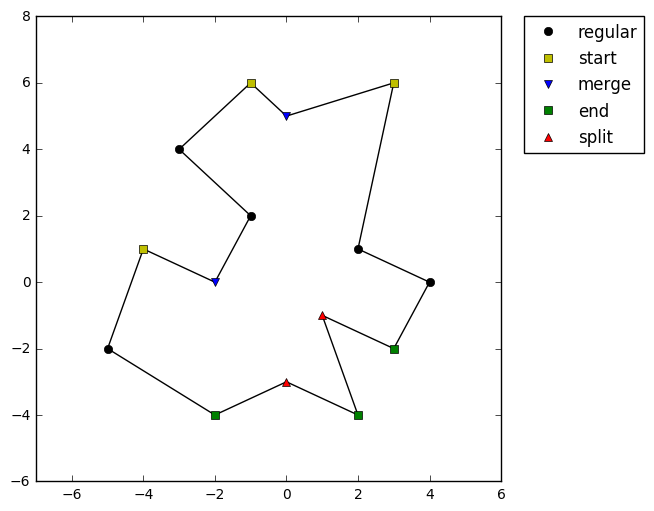

In [4]:
Point.__lt__ = point_comp # Используем свой компаратор для библиотечной точки

# Вершины многоугольника в порядке обхода против часовой стрелки
source = [(4, 0), (2, 1), (3, 6), (0, 5), (-1, 6), (-3, 4), (-1, 2), (-2, 0),
          (-4, 1), (-5, -2), (-2, -4), (0, -3), (2, -4), (1, -1), (3, -2)]
# Преобразовываем пары в наш класс
source = list(map(lambda i: Point(i[0], i[1]), source))
# Многоугольник хранится в DCEL
D = build_dcel(source)
for d in D:
    d.origin.vtype = compute_vtype(d)
draw_points(source, types=True)

### Лемма 1
> Многоугольник $y$-монотонный, если в нём нет `split` и `merge` вершин.

$\triangleright$
<div style="padding-left:40px">

Предположим, что $P$ не $y$-монотонный и покажем, что в нём есть такие вершины. Поскольку $P$ не $y$-монотонный, то мы можем найти такую прямую $l$, что она пересекает $P$ больше чем в одной компоненте связности. Не теряя общности, возьмём $l$ такую, что самый левый компонент пересечения - отрезок (а не точка). Пусть $p$ - левый конец этого отрезка, а $q$ - правый. Будем двигаться вверх от $q$ так, чтобы внутренность $P$ была слева от нас. В какой-то точке $r$ мы снова пересечём $l$. Если $r\ne p$ (см. рис. 2а), тогда самая высокая вершина, встреченная нами по пути, обязана быть `split`.<br>
<img src="illust/lemma1.svg"/>
Иначе (рис. 2б), пойдём снова от $q$ в другую сторону. Мы пересечём $l$ в точке $r'\ne r$, так как $l$ имеет минимум 3 точки пересечения с $P$. Аналогично предыдущему случаю, самая низкая вершина, встреченная нами на пути, обязана быть `merge`.
</div>

$\triangleleft$

### Заметающая прямая

Из леммы следует, что чтобы прямоугольник стал монотонным, нужно избавиться от `split` и `merge` вершин. Чтобы сделать это, мы будем проводить из них диагонали с помощью заметающей прямой.

Прямая будет двигаться по плоскости сверху вниз; событиями для неё будут служить вершины многоугольника с уже определённым нами порядком.
Чем меньше вершина, тем выше у неё приоритет в очереди. Поскольку в процессе обработки новые события не создаются, мы можем вместо приоритетной очереди использовать отсортированный список вершин.

Разберёмся, куда нам проводить диагонали, когда мы стоит в вершине $v_i$:

* `split` вершина.<br>Чтобы от ней избавиться, нужно провести диагональ вверх. Пусть $e_j$ - ребро непосредственно слева от нас, которое пересекла прямая, а $e_k$ - справа. Тогда мы всегда можем соединить $v_i$ с самой низкой вершиной между $e_j$ и $e_k$, которая выше $v_i$. Если такой нет, то мы можем соединить $v_i$ с верхним концом $e_j$ или $e_k$. Назовём эту вершину $\mathit{helper\,(e_j)}$.

<img src="illust/helpers.svg"/>

* `merge` вершина.<br>Тут будет немного сложнее, поскольку диагональ нужно проводить вниз - туда, где ещё не была заметающая прямая. Мы хотим соединить $v_i$ с самой высокой вершиной между $e_j$ и $e_k$, лежащей ниже $v_i$. Заметим, что это точная противоположность того, что мы делаем с `split` вершинами. Поэтому давайте запишем в $\mathit{helper\,(e_j)}$ текущую вершину $v_i$. Когда мы достигнем вершины $v_m$, она должна стать новым $\mathit{helper\,(e_j)}$, т.к. теперь она самая низкая слева от $e_j$. Поэтому каждый раз, когда мы обновляем $\mathit{helper}$, мы должны проверить, является ли старый $\mathit{helper}$ `merge` вершиной и если да, провести к нему диагональ.

На самом деле, ребро справа от нас нам, в общем-то, не нужно. Достаточно уметь эффективно находить ребро слева от вершины, в которой находится заметающая прямая, в каждый конкретный момент. Заметим, что такие рёбра будут все одной ориентации (направлены вниз), а ещё они никогда не будут пересекаться. Мы можем сложить их в бинарное дерево поиска, сравнивая по предикату поворота.

#### Задание 2 - компаратор для рёбер

Дополните функцию:

In [5]:
def comparator(self, other):
    """
    Сравнение для дерева поиска рёбер в сканлайне
    На вход подаётся два half-edge, из которых можно извлечь 4 вершины (Vertex)
    их концов. Можно использовать предикат поворота, как в предыдущей задаче.
    Требуется вернуть True, если ребро self находится левее other 
    на горизонтальной заметающей прямой. Гарантируется, что рёбра не пересекаются.
    """
    a = self.origin
    b = self.twin.origin
    c = other.origin
    d = other.twin.origin
    return comparator_answer(a,b,c,d) # Заглушка с функцией-ответом на задачу

Hedge.__lt__ = comparator # Добавляем компаратор к нашему классу

Тогда в дереве рёбра будут идти, как в прямоугольнике: слева направо, т.е. в порядке пересечения заметающей прямой. Вместе с каждым ребром в дереве мы можем хранить его $\mathit{helper}$. Процедура поиска будет выглядеть так:

In [6]:
T = SortedDict()  # Дерево, в котром ключи - рёбра, а значения - вершины-хелперы

def search_tree(hupper):
    """
    Возвращает наибольшее ребро слева от заданного
    """
    if hupper.origin < hupper.twin.origin:  # Сохраняем инвариант, что рёбра направлены вниз
        key = hupper
    else:
        key = hupper.twin
    i = T.bisect_left(key) - 1
    if i < 0:
        i = 0
    return T.iloc[i]

### Алгоритм

In [7]:
Q = list(sorted(source)) # Очередь вершин
D = build_dcel(source)   # Исходный многоугольник в формате DCEL
D1 = []                  # Добавленные диагонали будем хранить в отдельном списке для наглядной визуализации

Будем извлекать вершины из очереди по порядку, для каждой вершины возьмём её `half-edge` и вызовем функцию-обработчик, соответствующую типу вершины.
Обрабатывая вершину, мы должны сначала проверить, должны мы добавлять диагональ (это происходит, если текущая вершина `split` или если мы заменяем $\mathit{helper}$ и предыдущим был `merge`). Затем мы должны обновить соответствующим образом дерево, которое отражает состояние нашего алгоритма.

In [8]:
def update_helper(cur_hedge, key, new_helper):
    helper = T[key]
    if helper.vtype == VType.merge:
        D1.append(add_diagonal(cur_hedge, helper.hedge))
    if new_helper is None:
        del T[key]
    else:
        T[key] = new_helper

#### `start` вершина
Заметающая прямая начала "видеть" ребро из этой вершины, поэтому вставляем его в дерево

In [9]:
def handle_start(H):
    T[H] = H.origin

#### `end` вершина
Ребро, концом которого мы являемся, уходит из области видимости, поэтому его надо удалить из дерева. При этом проверяем, можем ли мы соединиться с его $\mathit{helper}$'ом.

In [10]:
def handle_end(H):
    update_helper(H, H.prev, None)

#### `split` вершина
Находим в дереве поиска ребро, лежащее слева от заметающей прямой, и проводим к его $\mathit{helper}$'у диагональ.
Теперь мы - $\mathit{helper}$ для этого ребра, т.к. предыдущий был выше. Кроме того, наше собственное ребро тоже нужно добавить в дерево.

In [11]:
def handle_split(H):
    lefte = search_tree(H)
    helper = T[lefte]
    D1.append(add_diagonal(H, helper.hedge))
    T[lefte] = H.origin
    T[H] = H.origin

#### `merge` вершина
Сначала нужно произвести действия, аналогичные `end`-у, т.к. предыдущее ребро кончилось.
После этого, мы должны найти ребро слева от нас и обновить его $\mathit{helper}$ на себя. (Соединившись с предыдущим, если он был `merge`).

In [12]:
def handle_merge(H):
    update_helper(H, H.prev, None)
    update_helper(H, search_tree(H), H.origin)

#### `regular` вершина
Тут нужно рассмотреть два случая:

1. Многоугольник $P$ лежит справа от $v_i$.<br>
Тогда нужно провести действия аналогично `end` для предыдущего ребра, и `start` для текущего.

2. $P$ лежит слева.<br>
Нужно найти в дереве ребро слева и обновить его $\mathit{helper}$, возможно проведя диагональ.

In [13]:
def handle_regular(H):
    if H.origin < H.twin.origin:  # Ребро направлено вниз, значит вершина в левой цепочке
        handle_end(H)
        handle_start(H)
    else:
        update_helper(H, search_tree(H), H.origin)

Ну и осталось собрать всё целиком:

In [14]:
def break_into_pieces(folder = '.pieces'):
    
    # С помощью этой функции мы будем делать "снимки" состояния алгоритма, чтобы потом
    # можно было посмотреть его по шагам.
    dump = create_dump_func(folder, visual_dump_pieces, D, D1, T, Q)

    for V in Q:
        dump(V)
        h = V.hedge
        if V.vtype == VType.start:
            handle_start(h)
        elif V.vtype == VType.end:
            handle_end(h)
        elif V.vtype == VType.split:
            handle_split(h)
        elif V.vtype == VType.merge:
            handle_merge(h)
        elif V.vtype == VType.regular:
            handle_regular(h)
        else:
            raise Exception('Type is unknown or not set')
    dump(None)
    
break_into_pieces()

Можно проследить за алгоритмом по шагам, используя виджет ниже.
Обычные рёбра чёрные, рёбра, которые лежат сейчас в дереве поиска - синие, а диагонали разбиения проведены синим пунктиром.

In [15]:
from IPython.display import display
display(SlideShower('.pieces'))

### Теорема 2 (коррекность):

> Приведённый выше алгоритм добавляет в многоугольник $P$ множество непересекающихся диагоналей, которые разбивают $P$ на $y$-монотонные части.

$\triangleright$

<div style="padding-left:40px">
Части $P$, на которые он был разбит, по построению не содержат `split` и `merge` вершин. Поэтому, по [Лемме 1](#Лемма-1) они $y$-монотонны. Теперь нам требуется доказать, что построенные диагонали не могут пересекать рёбер $P$ и пересекаться попарно. Покажем, что когда мы добавляем диагональ, она строится таким образом, что не может пересекать ни рёбер $P$, ни построенных на предыдущих шагах диагоналей.

Будем рассматривать случай выполнения `handle_split` - `split` вершины могут быть соединены не только с `merge` вершинами, в отличие от остальных. Случаи выполнения других функций рассматриваются аналогично.

<img src="illust/theorem2.svg" width=200 height=600 style="float: right; margin: 10px;" />

Рассмотрим диагональ $\overline{v_m v_i}$, которая была добавлена при вызове $\mathit{handle\_ split\,(v_i)}$ (см. рис.). Пусть $e_j$ - ребро слева от $v_i$ и $e_k$ - ребро справа от $v_i$. Из этого следует, что при вызове функции $\mathit{helper\,(e_j)}$ был равен $v_m$.<br>
Покажем,что $\overline{v_m v_i}$ не пересекается с рёбрами $P$. Рассмотрим четырёхугольник $Q$, образованный $e_j$, $e_k$ и горизонтальными прямыми, проходящими через $v_m$ и $v_i$. Внутри $Q$ нет вершин $P$, иначе $v_m$ не была бы $\mathit{helper}$'ом. Предположим, что там есть $e_s$ - ребро $P$, пересекающее $\overline{v_m v_i}$. Так как в $Q$ не может быть его концов и рёбра $P$ не пересекают сами себя, то $e_s$ пройдёт либо через горизонтальный отрезок, соединяющий $v_i$ и $e_j$, либо через горизонтальный отрезок, соединяющий $v_m$ и $e_j$. И то, и другое невозможно, т.к. и для $v_i$, и для $v_m$, ближайшим ребром слева является $e_j$.<br>
Теперь рассмотрим добавленную предыдущей диагональ. Так как в $Q$ нет вершин $P$, а концы любой построенной диагонали в силу порядка обхода должны лежать выше $v_i$, то она не может пересекаться с $\overline{v_m v_i}$.
</div>

$\triangleleft$

На самом деле, мы нигде не использовали тот факт, что многоугольник был простым. Поэтому этот алгоритм работает и для многоугольников с пустотами. Вы можете убедиться в этом на примере:

In [16]:
polygon = list(map(lambda i: Point(i[0], i[1]),
        [(3, 1), (0, 3), (-4, 2), (-2, 0), (-3, -1), (-2, -7), (1, -3), (3, -4), (4, -1)]))
# Точки "дырок" мы задаём уже по часовой стрелке - многоугольник снаружи них, а не внутри
hole = list(map(lambda i: Point(i[0], i[1]),
        [(0, 1), (1, 0), (0, -2), (-1, 0)])) 
hole2 = list(map(lambda i: Point(i[0], i[1]),
        [(-1, -2), (-1, -5), (-2, -3)]))

# Во всех функциях мы активно использовали замыкание вокруг структур данных,
# поэтому нам приходится переиспользовать их
T.clear()
D.clear()
D += build_dcel(polygon) + build_dcel(hole) + build_dcel(hole2)
for d in D:
    d.origin.vtype = compute_vtype(d)
D1.clear()
Q.clear()
Q += list(sorted(polygon + hole + hole2))

break_into_pieces('.pieces2')
from IPython.display import display
display(SlideShower('.pieces2'))

### Оценка асимптотики времени и памяти

Построение очереди $Q$ занимает $O(N)$, если использовать `heapify` и $O(N\log N)$ в случае обычной сортировки.<br>
Для обработки события мы производим одну операцию на $Q$, константное количество запросов, вставок и удалений на $T$, и создание от нуля до двух диагоналей. Из очереди мы можем достать за $O(\log N)$ или $O(1)$, операции поиска, вставки и удаления на сбалансированном бинарном дереве работают за $O(\log N)$, а диагонали создаются за $O(1)$. Итоговое время обработки одной вершины - $O(\log N)$. В очередь в процессе работы не добавляются события, а значит общее время работы равно $O(N\log{} N)$.

Каждая вершина хранится в $Q$ не больше чем в одном экземпляре, и каждое ребро хранится в $T$ не более чем в одном экземпляре. Поэтому расход памяти равен $O(N)$.

Итого, мы получили следующий результат:

> Многоугольник c $N$ вершинами может быть разбит на $y$-монотонные части алгоритмом, использующим $O(N\log N)$ времени и $O(N)$ памяти.